In [1]:

# Numbers
import numpy as np
import pandas as pd

# Serialization
import pickle

# Neural networks
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

# Machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Plotting
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

Using TensorFlow backend.


In [2]:

device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17434251368730919557, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11332668621
 locality {
   bus_id: 1
 }
 incarnation: 11423549508794071041
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"]

In [3]:
import os
    
def load_mouse_dynamics_dataset():
    
    training_sessions = []
    testing_sessions = []
    
    dataset_path = 'Mouse-Dynamics-Challenge'
    training_files_path = os.path.join(dataset_path, 'training_files')
    testing_files_path = os.path.join(dataset_path, 'test_files')
 
    # Load public labels, these are for the testing set, the labels only indicate if the user input
    # was produced by the real user or not
    labels_path = os.path.join(dataset_path, 'public_labels.csv')
    labels = pd.read_csv(labels_path)
    session_to_label = {labels['filename'][idx]: labels['is_illegal'][idx] for idx in range(len(labels))}
    
    user_names = os.listdir(training_files_path)
    
    # Load training and testing data for each user
    for user_name in user_names[:1]:
        
        user_id = user_name[4:]
        
        # Load training sessions
        user_training_path = os.path.join(training_files_path, user_name)
        training_session_names = os.listdir(user_training_path)
        
        for session_name in training_session_names:
            
            session_id = session_name[8:]
            df_session = pd.read_csv(os.path.join(user_training_path, session_name))
            
            training_sessions.append({ 
                'user_id': int(user_id), 
                'session_id' : int(session_id), 
                'data': df_session
            })
        
        # Load testing sessions
        user_testing_path = os.path.join(testing_files_path, user_name)
        testing_session_names = os.listdir(user_testing_path)
        
        for session_name in testing_session_names:
            
            session_id = session_name[8:]
            df_session = pd.read_csv(os.path.join(user_testing_path, session_name))
            
            # Some testing sessions doesn't have label, those are from the private dataset, only
            # the competition organizers had those labels. We don't save unlabeled sessions for now.
            try:
                is_illegal = session_to_label[session_name]
                
                testing_sessions.append({
                    # 
                    'user_id': int(user_id) if is_illegal == 0 else 0, 
                    'session_id' : int(session_id), 
                    'data': df_session
                })
            except KeyError:
                pass
                
    return training_sessions, testing_sessions
        
training_sessions, testing_sessions = load_mouse_dynamics_dataset()

In [6]:
training_sessions.shape

AttributeError: 'list' object has no attribute 'shape'

In [3]:
# Deserialize data
with open('dataset/local.pkl','rb') as f:
    local_data = pickle.load(f)
with open('dataset/remote.pkl','rb') as f:
    remote_data = pickle.load(f)
with open('dataset/other_local.pkl','rb') as f:
    other_data = pickle.load(f)

# Fix datasets and convert to pandas dataframe
df_local = pd.DataFrame(local_data['x'][:,:])
df_local['origin'] = 'USER0_LOCAL'

df_remote = pd.DataFrame(remote_data['x'][:,:])
df_remote['origin'] = 'USER0_REMOTE'

df_remote_user1 = pd.DataFrame(other_data['x'][:,:])
df_remote_user1 = df_remote_user1[df_remote_user1[2] == 'MOUSE_MOVE']
df_remote_user1['origin'] = 'USER1_LOCAL'

df = pd.concat([df_local, df_remote, df_remote_user1])
df.columns = ['dt', 'device', 'event_type', 'x', 'y', 'origin']
df['dt'] = pd.to_numeric(df['dt'])
df['x'] = pd.to_numeric(df['x'])
df['y'] = pd.to_numeric(df['y'])

orig_df = df.copy()

**Prepare data for machine learning, we will normalize the data and convert categorical variables to a number encoding**

---

In [4]:
# Numerical encoding for labels
label_encoder = LabelEncoder()
df['origin'] = label_encoder.fit_transform(df['origin'])

labels = label_encoder.inverse_transform([0, 1, 2])
print('Label encoding: 0 -> {} , 1 -> {}, 2 -> {}'.format(labels[0], labels[1], labels[2]))

# Remove outliers (no outliers in position data)
df = df[df.dt < df.dt.quantile(.95)]

# Give 0 mean and unit variance to data
standard_scaler = StandardScaler()
df['x'] = standard_scaler.fit_transform(df['x'].values.reshape(-1, 1))
df['y'] = standard_scaler.fit_transform(df['y'].values.reshape(-1, 1))
df['dt'] = standard_scaler.fit_transform(df['dt'].values.reshape(-1, 1))

Label encoding: 0 -> USER0_LOCAL , 1 -> USER0_REMOTE, 2 -> USER1_LOCAL


/home/ubuntu/data/installs/miniconda3/envs/dl-python35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


** Define hyperparameters **

---

In [79]:
seq_size = 130
# This could be wrong..
# Each time we train a batch we normalize every layer against an aproximated mean and variance which is taken from
# the mean and variance of the examples of the current batch. This mean and variance are also a averaged with the
# ones calculated for previous batches by using a runing average. 
# This parameter indicates how smoothly it changes across batches, in practice it makes the generalization error
# more noisy
batch_normalization_momentum = 0.2

**Divide data in subsequences, each subsequence will be a training example**

---

In [80]:
min_len = np.min([
    len(df[df.origin == 0]), len(df[df.origin == 1]), len(df[df.origin == 2])])

num_examples = min_len // seq_size

# Separate dataset in different classes
class0 = df[df.origin == 0][:num_examples * seq_size][['x', 'y', 'dt']].values
class1 = df[df.origin == 1][:num_examples * seq_size][['x', 'y', 'dt']].values
class2 = df[df.origin == 2][:num_examples * seq_size][['x', 'y', 'dt']].values

# Split in subsequences
class0_x = np.vsplit(class0, num_examples)
class1_x = np.vsplit(class1, num_examples)
class2_x = np.vsplit(class2, num_examples)

# Concatenate all features sequentially, (needed for scikit-learn) this works , why?
# class0_x = [ arr.reshape(seq_size*3) for arr in class0_x ]
# class1_x = [ arr.reshape(seq_size*3) for arr in class1_x ]
# class2_x = [ arr.reshape(seq_size*3) for arr in class2_x ]

# Create labels
class0_y = np.full(num_examples, 0, dtype=np.float32)
class1_y = np.full(num_examples, 1, dtype=np.float32)
class2_y = np.full(num_examples, 2, dtype=np.float32)

# Join all examples for different labels
x = np.concatenate([class0_x, class2_x], axis=0)
y = np.append(class0_y, class2_y)

# Random permutation of all the examples
permutation = np.random.permutation(len(y))
y = y[permutation]
x = x[permutation]

**Split into training and testing sets**

---

In [82]:

from keras.utils import np_utils
y = [0 if i == 0 else 1 for i in y]
y = np_utils.to_categorical(y, 2)

split = int(num_examples*2 * 0.8)
x_train = x[:split]
y_train = y[:split]
x_test = x[split:]
y_test = y[split:]

In [93]:
y_test.shape

(22, 2)

In [83]:
# OLD CODE
# data_points = np.min([len(remote['x']), len(local['x'])])
# seq_size = 50
# num_examples = data_points // seq_size
# # make data_points divisible by seq_size
# data_points = num_examples * seq_size
# remote_data = np.array(remote['x'][:data_points,0], dtype=np.float32)
# local_data = np.array(local['x'][:data_points,0], dtype=np.float32)
# # normalization
# remote_data_std = np.std(remote_data)
# remote_data_mean = np.mean(remote_data)
# remote_data = (remote_data - remote_data_mean) / (remote_data_std)

# local_data_std = np.std(local_data)
# local_data_mean = np.mean(local_data)
# local_data = (local_data - local_data_mean) / (local_data_std)
# # feature standardization
# classes = 2
# remote_data = (remote_data - remote_data.min())/(remote_data.max()-remote_data.min())*(classes-1)
# local_data = (local_data - local_data.min())/(local_data.max()-local_data.min())*(classes-1)

# remote_data = np.hsplit(remote_data, num_examples)
# local_data = np.hsplit(local_data, num_examples)

# y_remote = np.full(num_examples, 0, dtype=np.float32)
# y_local = np.full(num_examples, 1, dtype=np.float32)

# y = np.append(y_remote, y_local)

# from keras.utils import np_utils
# y = np_utils.to_categorical(y, classes)

# x = np.vstack((remote_data, local_data))

# permutation = np.random.permutation(len(y))
# y = y[permutation]
# x = x[permutation]

# split = int(num_examples*2 * 0.8)
# x_train = x[:split]
# y_train = y[:split]
# x_test = x[split+1:]
# y_test = y[split+1:]

# x_train = np.expand_dims(x_train, axis=2)
# x_test = np.expand_dims(x_test, axis=2)

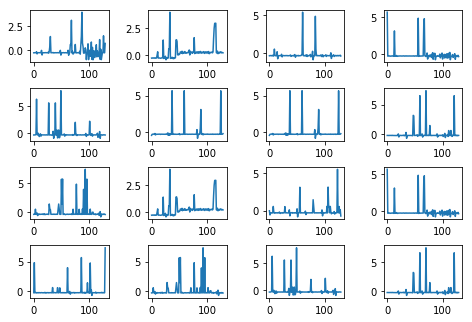

In [84]:
gs = gridspec.GridSpec(4, 4, top=1., bottom=0., right=1., left=0., hspace=0.5,
        wspace=0.5)
i = 0
for g in gs:
    ax = plt.subplot(g)
    ax.plot(x_train[np.random.randint(16)][:, 2])
    i += 1

In [85]:
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.core import Dense, Activation, Flatten

num_classes = 2
data_point_dimensionality = 3

model = Sequential([
        Conv1D(128, 8, padding='same', input_shape=(seq_size, data_point_dimensionality)),
        BatchNormalization(momentum=batch_normalization_momentum),
        LeakyReLU(),

        Conv1D(256, 5, padding='same'),
        BatchNormalization(momentum=batch_normalization_momentum),
        LeakyReLU(),

        Conv1D(128, 3, padding='same'),
        BatchNormalization(momentum=batch_normalization_momentum),
        LeakyReLU(),

        GlobalAveragePooling1D(),
        Dense(num_classes, activation='softmax')
])

# from model import get_model
# model = get_model((x_train.shape[1], 1), batch_normalization_momentum, classes, learning_rate)

In [86]:
for layer in model.layers:
    print("{:30}{} -> {}".format(layer.name, layer.input_shape, layer.output_shape))

conv1d_16                     (None, 130, 3) -> (None, 130, 128)
batch_normalization_16        (None, 130, 128) -> (None, 130, 128)
leaky_re_lu_16                (None, 130, 128) -> (None, 130, 128)
conv1d_17                     (None, 130, 128) -> (None, 130, 256)
batch_normalization_17        (None, 130, 256) -> (None, 130, 256)
leaky_re_lu_17                (None, 130, 256) -> (None, 130, 256)
conv1d_18                     (None, 130, 256) -> (None, 130, 128)
batch_normalization_18        (None, 130, 128) -> (None, 130, 128)
leaky_re_lu_18                (None, 130, 128) -> (None, 130, 128)
global_average_pooling1d_6    (None, 130, 128) -> (None, 128)
dense_6                       (None, 128) -> (None, 2)


In [87]:
learning_rate = 0.0000005

optimizer = Adam(lr=learning_rate)

In [88]:
epochs = 100
batch_size = 10

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

hist = model.fit(x_train, y_train, 
                 batch_size, epochs, 1, 
                 validation_data=(x_test, y_test))

# early_stopper = EarlyStopping(monitor = 'loss', patience=50) 
# hist = model.fit(x_train, y_train, 
#                  batch_size, epochs, 1, 
#                  validation_data=(x_test, y_test),
#                  callbacks = [early_stopper])

Train on 86 samples, validate on 22 samples
Epoch 1/100
86/86 [==============================] - 1s - loss: 0.6395 - acc: 0.6047 - val_loss: 0.6209 - val_acc: 0.5455
Epoch 2/100
86/86 [==============================] - 0s - loss: 0.6046 - acc: 0.6860 - val_loss: 0.4503 - val_acc: 0.7727
Epoch 3/100
86/86 [==============================] - 0s - loss: 0.6085 - acc: 0.7093 - val_loss: 0.4320 - val_acc: 0.8636
Epoch 4/100
86/86 [==============================] - 0s - loss: 0.5342 - acc: 0.7907 - val_loss: 0.4412 - val_acc: 0.8636

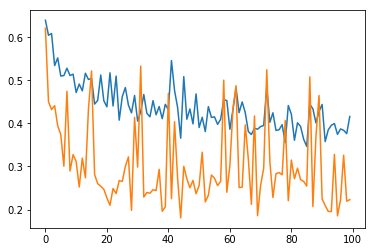

In [89]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

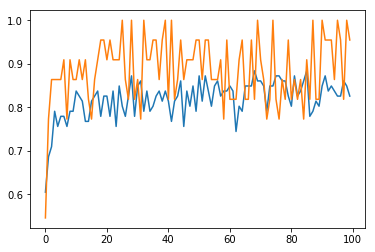

In [90]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

probar: bajar numero de samples
escalado del reentrenamiento

